# Рекомендация тарифов

В моём распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

**Цель:** построить модель с максимально большим значением *accuracy*. 

**План исследования:**
1. Открыть и изучить файл
2. Разбить данные на выборки
3. Исследуя модели, определить наиболее подходящую
4. Проверить модель на тестовой выборке
5. Проверить модели на адекватность
6. Вывод

## Изучение файла

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier #решающее дерево
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression #логистическая регрессия
from sklearn.dummy import DummyClassifier #проверка адекватности
import seaborn as sns

In [2]:
#записываем данные в переменную data
data = pd.read_csv('6.csv')

In [3]:
#отобразить первые 5 строк
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
#общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Итак, в нашем распоряжении 5 столбцов, 3214 строк. Признаки числовые(*calls, minutes, messages, mb_used*), целевой признак категориальный(*is_ultra*). Предобработка данных не требуется.

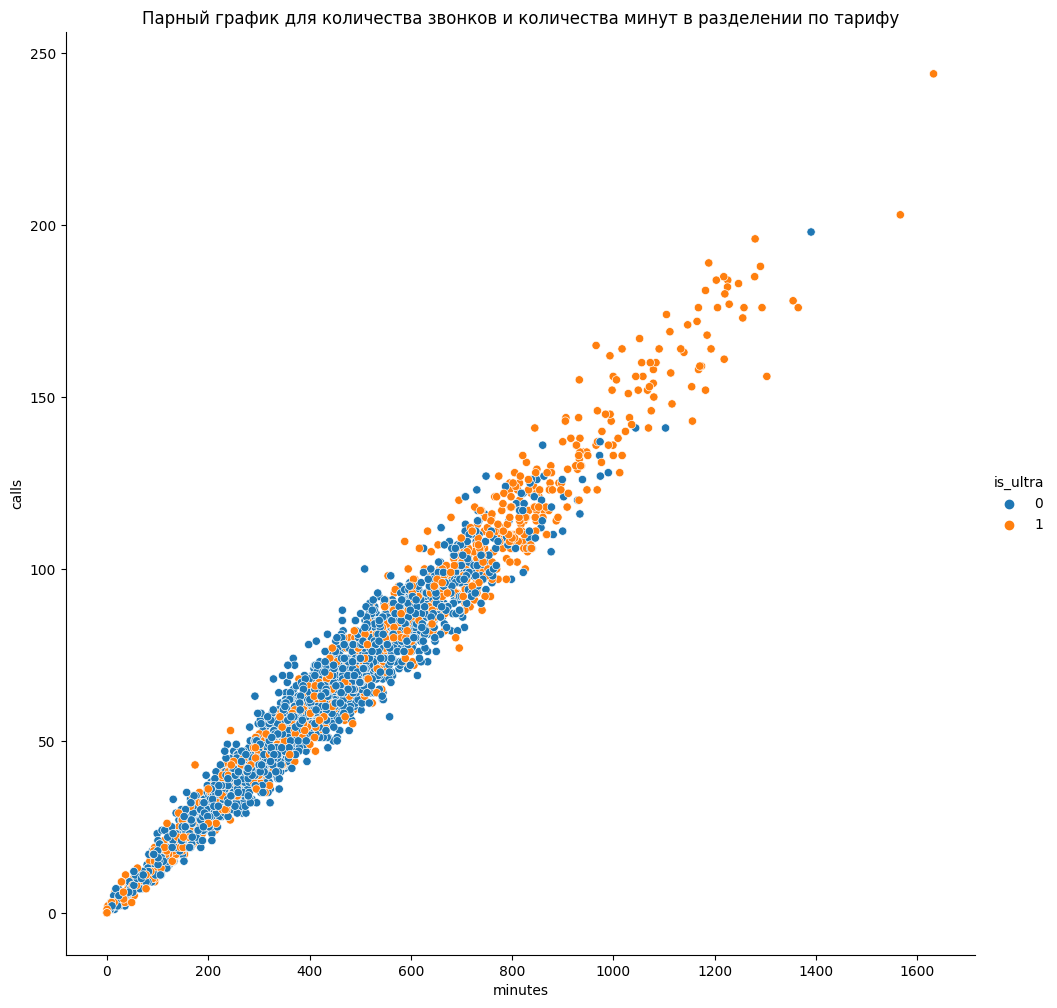

In [7]:
sns.pairplot(data, y_vars=['calls'], x_vars=['minutes'], hue='is_ultra', height=10).set(title='Парный график для количества звонков и количества минут в разделении по тарифу');

На графике выше действительно заметна сильная корреляция.
    
    
В связи с мультиколлинеарностью необходимо:
1. Определить коэффициент корреляции между двумя величинами
2. В случае, если он больше 0.7, удалить один из признаков
    
Корреляция двух независимых признаков может привести к переобучаемости модели

In [8]:
data.calls.corr(data.minutes)

0.9820832355742294

Корреляция 0.98 - величины действительно коллинеарны. Удалим столбец minutes.


In [9]:
data = data.drop('minutes', axis=1)

## Разделение данных на выборки

Так как спрятанной тестовой выборки у нет, то необходимо поделить данные на 3 части: обучающую, валидационную и тестовую. Чаще всего в подобных случаях данные делят в пропорции 3:1:1. Поступим также

In [10]:
#отделяем обучающую выборку
df_train, df_valid_test = train_test_split(data, test_size=0.4, random_state=45)
#отделяем валидационную и тестовую выборки
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=45)
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

## Исследование моделей

Перед исследованием моделей подготовим данные. В переменные *features_train* и *features_valid* запишем признаки для обучающей и валидационной выборок соответственно, в переменные *target_train* и *target_valid* - целевой признак соответственно.

In [11]:
#разделяем целевый признаки и обычные для обучающей и валидационной выборок
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

### Решающее дерево

Первая модель на рассмотрении - решающее дерево. Здесь будем оптимизировать по 3 параметрам:
1. *max_depth* — максимальная глубина дерева;
2. *min_samples_split* — минимальное число объектов в узле дерева, достаточное для дальнейшего разделения;
3. *min_samples_leaf* — минимальное число объектов в **листьях** дерева — нижних узлах с ответами.

In [12]:
#с помощью вложенных циклов определяем наилучшую комбинация гиперпараметров
best_model_tree = None
best_result_tree = 0
for depth in range(1, 10):
    for mss in range(2, 10):
        for msl in range(1, 10):
            model = DecisionTreeClassifier(random_state=45, max_depth=depth, min_samples_split=mss, min_samples_leaf=msl)
            model.fit(features_train, target_train) 
            result = model.score(features_valid, target_valid)
            if result > best_result_tree:
                best_model_tree = model
                best_result_tree = result
                best_params_tree = [depth, mss, msl]

print("Accuracy наилучшей модели на валидационной выборке:", best_result_tree)
print("Этот результат достигается при глубине дерева", best_params_tree[0], ", минимальном числе объектов в узле дерева", best_params_tree[1], 'и минимальном числе объектов в листьях дерева', best_params_tree[2])

Accuracy наилучшей модели на валидационной выборке: 0.7978227060653188
Этот результат достигается при глубине дерева 8 , минимальном числе объектов в узле дерева 2 и минимальном числе объектов в листьях дерева 5


### Случайный лес

Далее рассмотрим слуйчаный лес. Оптимизация по 2 параметрам:
1. *max_depth* — максимальная глубина дерева;
2. *n_estimators* — количество деревьев;

In [13]:
#с помощью вложенных циклов определяем наилучшую комбинация гиперпараметров
best_model_forest = None
best_result_forest = 0
for est in range(10, 250, 10):
    for depth in range(1, 8):
            model = RandomForestClassifier(random_state=45, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train) 
            result = model.score(features_valid, target_valid)
            if result > best_result_forest:
                best_model_forest = model
                best_result_forest = result
                best_params_forest = [est, depth]

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("Этот результат достигается при количестве деревьев", best_params_forest[0], "и глубине дерева", best_params_forest[1])

Accuracy наилучшей модели на валидационной выборке: 0.8055987558320373
Этот результат достигается при количестве деревьев 20 и глубине дерева 7


### Логистическая регрессия

Логистическая регрессия. Оптимизировать будем только один параметр - *max_iter* - максимальное количество итераций

In [14]:
#с помощью вложенных циклов определяем наилучшую комбинация гиперпараметров
best_model_log_res = None
best_result_log_res = 0
for mit in range(100, 5000, 100):
    model = LogisticRegression(solver='lbfgs', random_state=45, max_iter=mit)
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid)
    if result > best_result_log_res:
        best_model_log_res = model
        best_result_log_res = result
        best_params_log_res = mit

print("Accuracy наилучшей модели на валидационной выборке:", best_result_log_res)
print("Этот результат достигается при количестве итераций", best_params_log_res)

Accuracy наилучшей модели на валидационной выборке: 0.7293934681181959
Этот результат достигается при количестве итераций 100


**Вывод**

По результатам оценки точности с помощью валидационной выборки наилучший результат - 0.8 - показала модель случайного леса с 16 деревьями и глубиной дерева 8. Решающее дерево не сильно отстало, показав результат меньше всего на 0.01. Хуже всего проявила себя логистическая регрессия, accuracy достигло всего 0.72 при максимальном количестве итераций 100.

## Проверка моделей на тестовой выборке

In [15]:
result_tree = best_model_tree.score(features_test, target_test)
result_forest = best_model_forest.score(features_test, target_test)
result_log_res = best_model_log_res.score(features_test, target_test)
print('Accuracy решающего дерева на тестовой выборке:', result_tree)
print('Accuracy случайного леса на тестовой выборке:', result_forest)
print('Accuracy логистической регрессии на тестовой выборке:', result_log_res)

Accuracy решающего дерева на тестовой выборке: 0.7900466562986003
Accuracy случайного леса на тестовой выборке: 0.7978227060653188
Accuracy логистической регрессии на тестовой выборке: 0.7402799377916018


Как и на обучающей выборке, лучший результат продемонстрировала модель случайного леса, достигнув accuracy 0.79.

## Проверка модели на адекватность

Проверку моделей на адекватность будем осуществлять с помощью DummyClassifier. Суть в том, что мы обучаем модель DummyClassifier с параметром *stratified*(это означает, что предсказания даются случаным образом) на обучающей выборке, затем на валидационной считаем accuracy. Затем полученное значение accuracy необходимо сравнить с accuracy моделей на валидационной выборке. Если accuracy моделей больше, чем у DummyClassifier, то модели адекватны.

In [16]:
model_dummy = DummyClassifier(strategy='stratified')
model_dummy.fit(features_train, target_train)
result_dummy = model_dummy.score(features_valid, target_valid)
print('Accuracy случайной модели на валидационной выборке:', result_dummy)
print('Accuracy решающего дерева на валидационной выборке:', best_result_tree)
print('Accuracy случайного леса на валидационной выборке:', best_result_forest)
print('Accuracy логистической регресии на валидационной выборке:', best_result_log_res)

Accuracy случайной модели на валидационной выборке: 0.5754276827371695
Accuracy решающего дерева на валидационной выборке: 0.7978227060653188
Accuracy случайного леса на валидационной выборке: 0.8055987558320373
Accuracy логистической регресии на валидационной выборке: 0.7293934681181959


Так как accuracy всех моделей превосходит accuracy случайной модели, то проверку на адекватность можно считать пройденной.

## Вывод

В ходе данного исследования была подобрана наилучшая модель с наилучшими параметрами под конкретную задачу. В нашем случае этой моделью оказался случайный лес с 16 деревьями и глубиной дерева 8. Несмотря на это, все модели на тестовой выборке показали результат больше 0.75, однако случайный лес и тут проявил себя лучше всех, достигнув accuracy 0.81. Затем все рассмотренные модели были протестированы на адекватность и успешно справились с тестом.